# Setup and Environment Configuration

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, f1_score
import seaborn as sns
import shap
import uuid
from datetime import datetime
import time
import zipfile
import shutil

from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/dataset/absT.zip"
extract_path = "/content/absT"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("absT.zip unpacked to /content/absT")

DATASET_DIR = "/content/absT/absT"
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, "train", "images")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "train", "labels")
VALID_IMAGE_DIR = os.path.join(DATASET_DIR, "valid", "images")
VALID_LABEL_DIR = os.path.join(DATASET_DIR, "valid", "labels")
MODEL_SAVE_PATH = "/content/drive/MyDrive/model"
OUTPUT_DIR = "/content/drive/MyDrive/output"

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASSES = ['annular', 'bubbly', 'churn', 'slug', 'transition_bubbly-slug',
           'transition_churn-annular', 'transition_slug-churn']
NUM_CLASSES = len(CLASSES)

IMG_WIDTH = 96
IMG_HEIGHT = 598

torch.manual_seed(42)
np.random.seed(42)

Mounted at /content/drive
absT.zip unpacked to /content/absT


In [ ]:
# Debug
def count_files(folder, extensions=('.jpg', '.png', '.jpeg')):
    try:
        return len([f for f in os.listdir(folder) if f.lower().endswith(extensions)])
    except FileNotFoundError:
        print(f"Folder not found: {folder}")
        return 0

def count_labels(folder, extensions=('.txt',)):
    try:
        return len([f for f in os.listdir(folder) if f.lower().endswith(extensions)])
    except FileNotFoundError:
        print(f"Folder not found: {folder}")
        return 0

print("\nDataset Overview")
print("-" * 40)
print(f"Train Images: {count_files(TRAIN_IMAGE_DIR)}")
print(f"Train Labels: {count_labels(TRAIN_LABEL_DIR)}")
print(f"Valid Images: {count_files(VALID_IMAGE_DIR)}")
print(f"Valid Labels: {count_labels(VALID_LABEL_DIR)}")
print("-" * 40)


Dataset Overview
----------------------------------------
Train Images: 1921
Train Labels: 1921
Valid Images: 411
Valid Labels: 411
----------------------------------------


# Custom Dataset Class

In [ ]:
class FlowPatternDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.0

        label = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if lines:
                    label = int(lines[0].split()[0])

        if self.transform:
            image = self.transform(image)

        image_tensor = torch.FloatTensor(image).permute(2, 0, 1)
        return image_tensor, torch.tensor(label, dtype=torch.long)

# PINN Classifier Model Definition

In [ ]:
class PINNFlowClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PINNFlowClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4), 128)
        self.dropout2 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.lambda_phys = 0.1

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def physics_loss(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        grad_x = torch.pow(x[:, :, :-1, :] - x[:, :, 1:, :], 2).mean() / (x.mean() + 1e-8)
        grad_y = torch.pow(x[:, :, :, :-1] - x[:, :, :, 1:], 2).mean() / (x.mean() + 1e-8)
        return self.lambda_phys * 100 * (grad_x + grad_y)

# Data Loading and Initialization

In [ ]:
train_dataset = FlowPatternDataset(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
valid_dataset = FlowPatternDataset(VALID_IMAGE_DIR, VALID_LABEL_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model = PINNFlowClassifier(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training Loop

In [ ]:
num_epochs = 50
train_losses, valid_losses = [], []
train_phys_losses, valid_phys_losses = [], []
train_accuracies, valid_accuracies = [], []
epoch_times = []

best_valid_loss = float("inf")
best_model_path = os.path.join(MODEL_SAVE_PATH, "pinn_best_flow_classifier.pt")

start_training = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    train_loss = 0
    train_phys_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        phys_loss = model.physics_loss(images)
        total_loss = loss + phys_loss
        total_loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_phys_loss += phys_loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_phys_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    valid_loss = 0
    valid_phys_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            phys_loss = model.physics_loss(images)

            valid_loss += loss.item()
            valid_phys_loss += phys_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

    valid_loss /= len(valid_loader)
    valid_phys_loss /= len(valid_loader)
    valid_accuracy = correct_valid / total_valid

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_phys_losses.append(train_phys_loss)
    valid_phys_losses.append(valid_phys_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    epoch_duration = time.time() - epoch_start
    epoch_times.append(epoch_duration)

    print(f"Epoch [{epoch+1}/{num_epochs}] {epoch_duration:.2f}s | "
          f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | "
          f"Train Acc: {train_accuracy:.4f} | Valid Acc: {valid_accuracy:.4f} | "
          f"Phys (Train): {train_phys_loss:.4f} | Phys (Valid): {valid_phys_loss:.4f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved (Validation Loss: {best_valid_loss:.4f})")

total_training_time = time.time() - start_training
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
print(f"Best model saved as: {best_model_path}")

Epoch [1/50] 12.26s | Train Loss: 1.2148 | Valid Loss: 0.7481 | Train Acc: 0.4930 | Valid Acc: 0.6740 | Phys (Train): 0.1377 | Phys (Valid): 0.1013
New best model saved (Validation Loss: 0.7481)
Epoch [2/50] 11.65s | Train Loss: 0.8482 | Valid Loss: 0.5872 | Train Acc: 0.6216 | Valid Acc: 0.8224 | Phys (Train): 0.0945 | Phys (Valid): 0.0857
New best model saved (Validation Loss: 0.5872)
Epoch [3/50] 10.88s | Train Loss: 0.7009 | Valid Loss: 0.5169 | Train Acc: 0.6892 | Valid Acc: 0.7835 | Phys (Train): 0.0801 | Phys (Valid): 0.0738
New best model saved (Validation Loss: 0.5169)
Epoch [4/50] 11.80s | Train Loss: 0.6386 | Valid Loss: 0.5052 | Train Acc: 0.6976 | Valid Acc: 0.8200 | Phys (Train): 0.0699 | Phys (Valid): 0.0665
New best model saved (Validation Loss: 0.5052)
Epoch [5/50] 12.26s | Train Loss: 0.6045 | Valid Loss: 0.6013 | Train Acc: 0.7309 | Valid Acc: 0.7713 | Phys (Train): 0.0630 | Phys (Valid): 0.0626
Epoch [6/50] 10.12s | Train Loss: 0.6183 | Valid Loss: 0.5138 | Train Ac

In [ ]:
# Accuracy storage
accuracies = {}

def evaluate_model(data_loader, set_name):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    accuracies[set_name] = accuracy

evaluate_model(train_loader, 'Training')
evaluate_model(valid_loader, 'Validation')

# Print combined accuracies
print("\nAccuracy Report")
print("-" * 40)
print(f"Training Accuracy: {accuracies['Training'] * 100:.2f}")
print(f"Validation Accuracy: {accuracies['Validation'] * 100:.2f}%")
print("-" * 40)


Accuracy Report
----------------------------------------
Training Accuracy: 99.38
Validation Accuracy: 85.16%
----------------------------------------


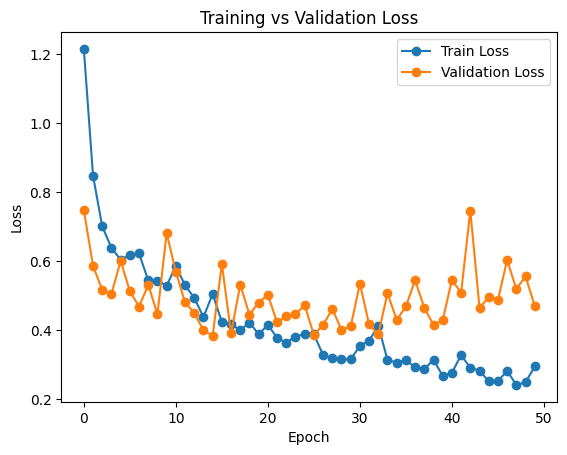

In [ ]:
# Loss Curves
plt.figure()
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(valid_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'pinn_loss_graph.png'))
plt.show()
plt.close()

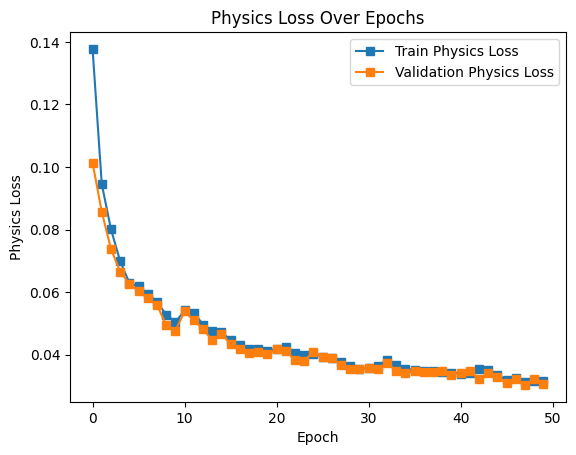

In [ ]:
# Physics Loss Curves
plt.figure()
plt.plot(train_phys_losses, label='Train Physics Loss', marker='s')
plt.plot(valid_phys_losses, label='Validation Physics Loss', marker='s')
plt.title('Physics Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Physics Loss')
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'pinn_physics_loss_graph.png'))
plt.show()
plt.close()

# Save Model

In [ ]:
torch.save(model, 'pinn_model3.pt')

drive_folder = '/content/drive/MyDrive/model'
os.makedirs(drive_folder, exist_ok=True)

drive_model_path = os.path.join(drive_folder, 'pinn_model3.pt')
shutil.move('pinn_model3.pt', drive_model_path)

print(f"model saved to Drive at:\n{drive_model_path}")

model saved to Drive at:
/content/drive/MyDrive/model/pinn_model3.pt
